In [14]:
import numpy as np
from matplotlib import pyplot as plt
from bta import *
import os
import tdt
import scipy.stats as stats
from sklearn.metrics import auc


In [2]:
# set folder where all the files you want to analyze are
dir = r"C:\Users\maxma\OneDrive\Desktop\Shared Fiber Pho\FiberPhoStuff\data"
# create empty list (bpa) and add all the .tev files to that list
bpa = []
for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".tev"):
                  bpa.append(root)

In [3]:
from bta._types import TDTEpoc, TDTStream

def get_data(epoc: TDTEpoc, event_code: list[int], gfp: TDTStream, iso: TDTStream, TRANGE: tuple[int, int], BASELINE_PER: tuple[int, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Get Epoc average data for GFP and ISO streams

    Parameters
    ----------
    epoc : TDTEpoc
        the epoc
    event_code : list[int]
        the event code
    gfp : TDTStream
        the GFP stream
    iso : TDTStream
        the ISO stream
    TRANGE : tuple[int, int]
        the time range
    BASELINE_PER : tuple[int, int]
        the baseline period

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        the mean_iso, mean_gfp, iso_vec, gfp_vec, std_iso, std_gfp
    """
    trs = get_time_ranges(epoc, values=event_code)
    filtered_trs = modify_time_ranges(epoc, TRANGE, trs)
    filtered_gfp = get_filtered_stream_data(gfp, filtered_trs)
    filtered_iso = get_filtered_stream_data(iso, filtered_trs)
    min1 = np.min([np.size(x) for x in filtered_gfp])
    min2 = np.min([np.size(x) for x in filtered_iso])
    # filtered_gfp = [x[1:min1] for x in filtered_gfp]
    # filtered_iso = [x[1:min2] for x in filtered_iso]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F405 = []
    F465 = []
    for lst in filtered_iso:
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F405.append(small_lst)

    for lst in filtered_gfp: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)


    #Create a mean signal, standard error of signal, and DC offset
    mean_iso = np.mean(F405, axis=0)
    std_iso = np.std(F405, axis=0)/np.sqrt(len(filtered_iso))
    dc_iso = np.mean(mean_iso)
    mean_gfp = np.mean(F465, axis=0)
    std_gfp = np.std(F465, axis=0)/np.sqrt(len(filtered_gfp))
    dc_gfp = np.mean(mean_gfp)

    # Create the time vector for each stream store
    gfp_vec = TRANGE[0] + np.linspace(1, len(mean_gfp), len(mean_gfp))/gfp.fs*N
    iso_vec = TRANGE[0] + np.linspace(1, len(mean_iso), len(mean_iso))/iso.fs*N

    # Subtract DC offset to get signals on top of one another
    mean_iso = mean_iso - dc_iso
    mean_gfp = mean_gfp - dc_gfp

    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F405, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)

    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(iso_vec)<BASELINE_PER[1]) & (np.array(iso_vec)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)

        zerror = np.std(zall, axis=0)/np.sqrt(np.size(zall, axis=0))

    return zall, zerror, iso_vec, gfp_vec




In [30]:

#creates empty dictionary where we will add the data
to_analyze= {}

for idx, block_path in enumerate(bpa):
    # load data
    data = read_block(block_path)
    tdt_data = tdt.read_block(block_path)
    epoc_to_analyze = data.get_epoc("PrtB")
    epoc_to_analyze.onset = tdt_data.epocs.PrtB.onset
    epoc_to_analyze.offset = tdt_data.epocs.PrtB.offset
    epoc_to_analyze.data = tdt_data.epocs.PrtB.data
    gfp = data.get_stream("GFPG")
    gfp.data = tdt_data.streams.GFPG.data
    iso = data.get_stream("ISOG")
    iso.data = tdt_data.streams.ISOG.data

    # gets data around epoch. The 'if' statement is there to correct for running different programs that output different numbers for the epoch (in this case 38 vs 34)
    if idx == 1:
        zall, zerror, iso_vec, gfp_vec = get_data(epoc_to_analyze, [38], gfp, iso, [-10, 30], [-10, 0])
    else:
        zall, zerror, iso_vec, gfp_vec = get_data(epoc_to_analyze, [34], gfp, iso, [-10, 30], [-10, 0])

    # adds zall, zerror, iso_vec, and gfp_vec data to dictionary 'to_analyze'
    to_analyze[block_path] = {
        "zall": zall,
        "zerror": zerror,
        "iso_vec": iso_vec,
        "gfp_vec": gfp_vec
    }
    # puts out raw data before averaging into separate csv files
    # change to if True to output the data
    if False:
        fname = os.path.join("C:/Users/maxma/OneDrive/Desktop/Fiber Pho Data/Analyzed Data", os.path.basename(block_path) + "-zall.csv")
        np.savetxt(fname, zall, delimiter=",")
        fname = os.path.join("C:/Users/maxma/OneDrive/Desktop/Fiber Pho Data/Analyzed Data", os.path.basename(block_path) + "-zerror.csv")
        np.savetxt(fname, zerror, delimiter=",")
        fname = os.path.join("C:/Users/maxma/OneDrive/Desktop/Fiber Pho Data/Analyzed Data", os.path.basename(block_path) + "-isovec.csv")
        np.savetxt(fname, iso_vec, delimiter=",")
        fname = os.path.join("C:/Users/maxma/OneDrive/Desktop/Fiber Pho Data/Analyzed Data", os.path.basename(block_path) + "-gfpvec.csv")
        np.savetxt(fname, gfp_vec, delimiter=",")

# create empty arrays for the data we will create by averaging together each 'frame' from each file
zrow = np.shape(zall)[0]
zcol = np.shape(zall)[1]
nf = len(bpa)
sumzall = np.zeros((zrow,zcol))
sumzerr = np.zeros(zcol)
sumiso = np.zeros(zcol)
sumgfp = np.zeros(zcol)

# fill arrays with the sums of each 'frame' 
for f,val in to_analyze.items():
    sumzall = np.add(sumzall, val["zall"])
    sumzerr = np.add(sumzerr, val["zerror"])
    sumiso = np.add(sumiso, val["iso_vec"])
    sumgfp = np.add(sumgfp, val["gfp_vec"])

# divide each 'frame' by the number of files to get the data averaged
avgzall = np.divide(sumzall, nf)
avgzerr = np.divide(sumzerr, nf)
avgiso = np.divide(sumiso, nf)
avggfp = np.divide(sumgfp, nf)

read from t=0s to t=2113.44s
read from t=0s to t=2126.7s


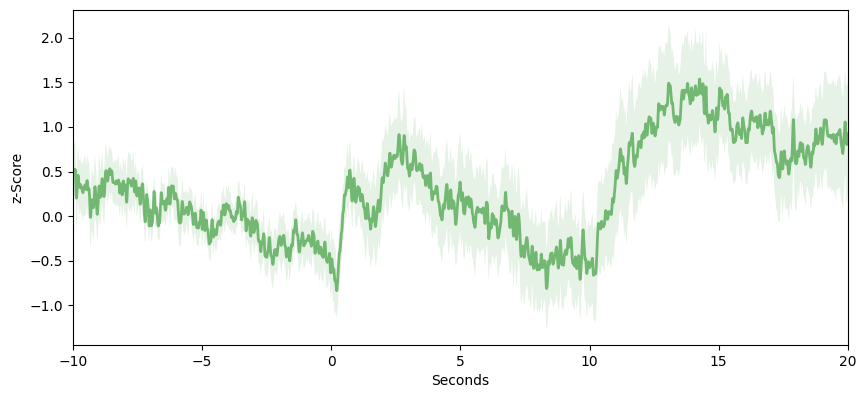

In [5]:
# create a z-score plot of all the data across all the files around the epoch of interest
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('z-Score')
ax1.set_xlabel('Seconds')
ax1.set_xlim(-10, 20)
ax1.set_label('z-Score')
ax1.plot(avgiso, np.mean(avgzall, axis = 0), linewidth=2, color='green', alpha=0.5)
ax1.fill_between(avggfp, np.mean(avgzall, axis=0)+avgzerr
                    ,np.mean(avgzall, axis=0)-avgzerr, facecolor='green', alpha=0.1)


Text(0.5, 0, 'Seconds from Cue Onset')

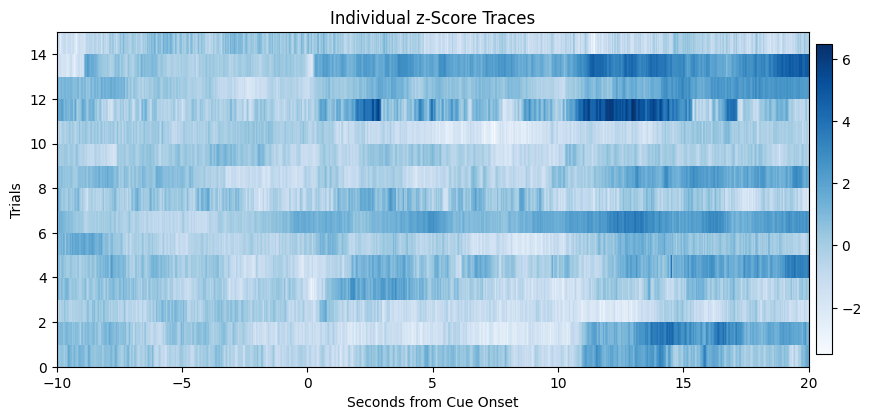

In [11]:
#create a heatmap of the data across all files
TRANGE = [-10,30]
fig = plt.figure(figsize=(10, 20))
ax3 = fig.add_subplot(412)
cs = ax3.imshow(avgzall, cmap=plt.cm.Blues, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, zrow])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax3.set_title('Individual z-Score Traces')
ax3.set_ylabel('Trials')
ax3.set_xlabel('Seconds from Cue Onset')

In [27]:
print("zall data:", avgzall)

zall data: [[-1.82566988 -1.85830927 -1.74708182 ... -0.34648788 -0.29493219
  -0.22306716]
 [-1.32127139 -1.37739173 -1.43120843 ...  4.84047705  4.6445353
   4.46557462]
 [ 1.20721209  1.24377668  1.31798244 ...  2.52714223  2.5457409
   2.5608685 ]
 ...
 [-0.44201475 -0.48554277 -0.55687618 ... -1.60342181 -1.60326827
  -1.53958631]
 [ 1.34714282  1.35913235  1.3153944  ...  1.26991333  1.38439962
   1.53612888]
 [ 0.98026934  1.08978289  1.03948152 ...  1.62980267  1.56482506
   1.57471281]]


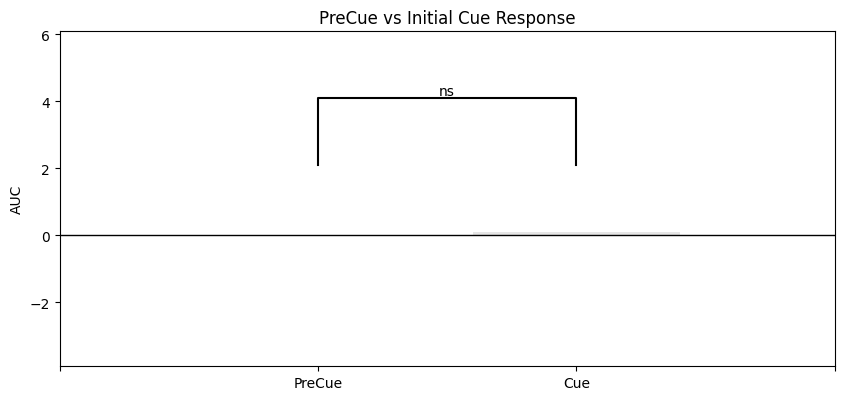

In [26]:
# show bar graph of area under curve. Doesn't work right now. Not sure why
AUC = [] # precue, cue
ind1 = np.where((np.array(avgiso)<0) & (np.array(avgiso)>-10))
AUC1= auc(avgiso[ind1], np.mean(avgzall, axis=0)[ind1])
ind2 = np.where((np.array(avgiso)>0) & (np.array(avgiso)<10))
AUC2= auc(avgiso[ind2], np.mean(avgzall, axis=0)[ind2])
AUC.append(AUC1)
AUC.append(AUC2)

# Run a two-sample T-test
t_stat,p_val = stats.ttest_ind(np.mean(avgzall, axis=0)[ind1],
                               np.mean(avgzall, axis=0)[ind2], equal_var=False)

fig = plt.figure(figsize=(10, 20))
ax3 = fig.add_subplot(413)
p9 = ax3.bar(np.arange(len(AUC)), AUC, color=[.8, .8, .8], align='center', alpha=0.5)

# statistical annotation
if p_val<.05:
    x1, x2 = 0, 1 # columns indices for labels
    y, h, col = max(AUC) + 2, 2, 'k'
    ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    p10 = ax3.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    x1, x2 = 0, 1 # columns indices for labels
    y, h, col = max(AUC) + 2, 2, 'k'
    ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    p10 = ax3.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
# Finish up the plot
# ax3.set_ylim(0,y+2*h)
ax3.set_ylim(y-2*h-2,y+2*h)
ax3.set_ylabel('AUC')
ax3.set_title('PreCue vs Initial Cue Response')
ax3.set_xticks(np.arange(-1, len(AUC)+1))
ax3.set_xticklabels(['','PreCue','Cue',''])
ax3.axhline(y=0, linewidth=1, color='black')

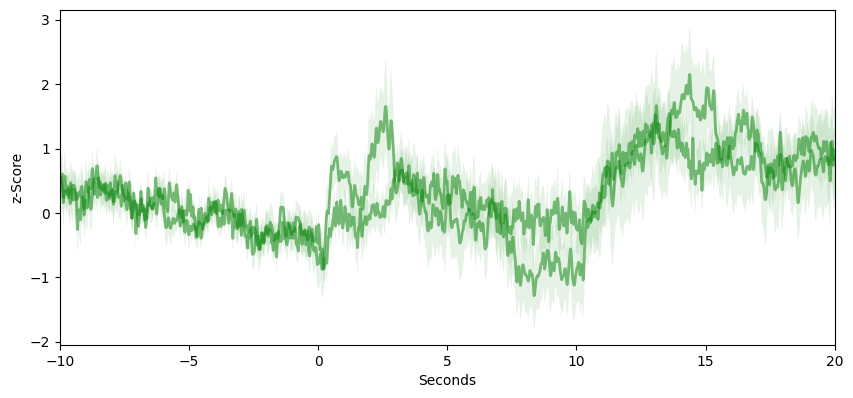

In [12]:
# create a z-score plot with each file plotted as its own line
fig = plt.figure(figsize=(10, 20))
ax2 = fig.add_subplot(411)
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(-10, 20)
ax2.set_label('z-Score')
for block_path in to_analyze:
    ax2.plot(to_analyze[block_path]["iso_vec"], np.mean(to_analyze[block_path]["zall"], axis=0), linewidth=2, color='green', alpha=0.5)
    ax2.fill_between(to_analyze[block_path]["gfp_vec"], np.mean(to_analyze[block_path]["zall"], axis=0)+to_analyze[block_path]["zerror"]
                      ,np.mean(to_analyze[block_path]["zall"], axis=0)-to_analyze[block_path]["zerror"], facecolor='green', alpha=0.1)
